In [2]:
import pandas as pd
import numpy as np
import keras
from keras.layers import Input, Dense, LSTM, Embedding, concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
data_feat = pd.read_csv('power_consumption_g2_feat.csv')

In [4]:
data_res = pd.read_csv('power_consumption_g2.csv')

In [5]:
data_feat

,TimePeriod,WT,WH,WS,GDF,DF
0,2017-03-01 16:40:00,21.33,55.91,0.080,387.400,427.300
1,2017-07-27 06:30:00,23.10,48.58,4.908,10.450,8.630
2,2017-10-11 19:00:00,23.10,59.82,0.084,0.446,0.322
3,2017-02-10 06:50:00,12.25,80.80,4.916,0.051,0.111
4,2017-03-06 16:00:00,15.62,59.38,0.075,533.400,579.900
...,...,...,...,...,...,...
52411,2017-05-14 02:20:00,23.58,43.10,0.075,0.110,0.122
52412,2017-11-17 19:20:00,17.30,76.50,0.075,0.040,0.148
52413,2017-03-21 12:10:00,17.90,50.28,0.081,837.000,296.700
52414,2017-07-28 05:10:00,25.23,61.32,4.907,0.091,0.119


In [6]:
data_res

,TimePeriod,Consumption
0,2017-12-02 20:10:00,36824.33460
1,2017-12-25 15:30:00,31841.82510
2,2017-05-19 21:10:00,44909.11475
3,2017-05-28 04:50:00,22964.45902
4,2017-05-08 16:10:00,33829.77049
...,...,...
52411,2017-10-01 23:50:00,31138.03063
52412,2017-12-07 17:40:00,40091.25475
52413,2017-09-11 18:30:00,38930.97345
52414,2017-04-16 04:50:00,23734.42411


In [7]:
data_feat['TimePeriod'] = pd.to_datetime(data_feat['TimePeriod'])
data_feat.set_index('TimePeriod', inplace=True)
data_feat.sort_index(inplace=True)

In [8]:
data_feat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52416 entries, 2017-01-01 00:00:00 to 2017-12-30 23:50:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WT      51857 non-null  float64
 1   WH      51917 non-null  float64
 2   WS      51887 non-null  float64
 3   GDF     51892 non-null  float64
 4   DF      51911 non-null  float64
dtypes: float64(5)
memory usage: 2.4 MB


In [10]:
data_res['TimePeriod'] = pd.to_datetime(data_res['TimePeriod'])
data_res.set_index('TimePeriod', inplace=True)
data_res.sort_index(inplace=True)

In [11]:
data_res.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52416 entries, 2017-01-01 00:00:00 to 2017-12-30 23:50:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  52416 non-null  float64
dtypes: float64(1)
memory usage: 819.0 KB


In [12]:
data = pd.merge(left=data_feat, right=data_res, left_index=True, right_index=True)

In [13]:
data

,WT,WH,WS,GDF,DF,Consumption
TimePeriod,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620
...,...,...,...,...,...,...
2017-12-30 23:10:00,7.010,72.4,0.080,NaN,0.096,31160.45627
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452


In [14]:
data.isnull().sum()

WT             559
WH             499
WS             529
GDF            524
DF             505
Consumption      0
dtype: int64

In [16]:
features = data.columns.tolist()[:-1]
features

['WT', 'WH', 'WS', 'GDF', 'DF']

In [17]:
for feature in features:
    data[feature] = data[feature].interpolate(method='linear')

In [18]:
data.isnull().sum()

WT             0
WH             0
WS             0
GDF            0
DF             0
Consumption    0
dtype: int64

In [19]:
data = data.groupby(pd.Grouper(freq='38min')).mean()

In [20]:
data

,WT,WH,WS,GDF,DF,Consumption
TimePeriod,,,,,,
2017-01-01 00:00:00,6.351750,74.450000,0.082250,0.068500,0.10000,30306.835442
2017-01-01 00:38:00,5.709750,77.050000,0.081750,0.052500,0.09550,26351.392405
2017-01-01 01:16:00,5.539000,77.400000,0.081750,0.059500,0.12150,24124.556962
2017-01-01 01:54:00,4.974750,78.850000,0.082750,0.066250,0.11950,22332.151897
2017-01-01 02:32:00,5.198667,78.700000,0.082000,0.059667,0.13500,21425.822783
...,...,...,...,...,...,...
2017-12-30 21:02:00,7.826667,70.576667,0.081333,0.068333,0.09900,35581.242077
2017-12-30 21:40:00,7.880000,69.855000,0.081250,0.067750,0.09550,34679.847910
2017-12-30 22:18:00,7.465000,70.825000,0.082250,0.056750,0.11125,33575.665400


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

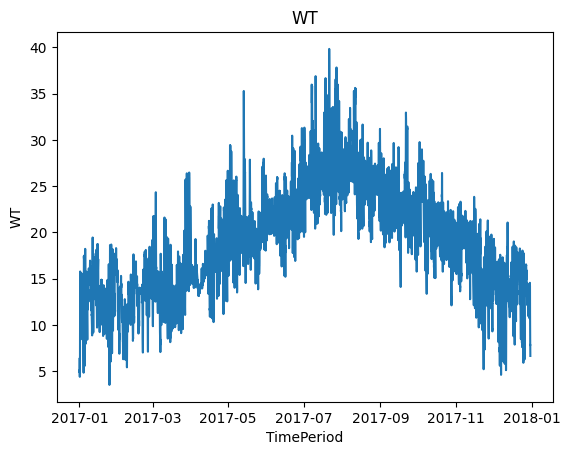

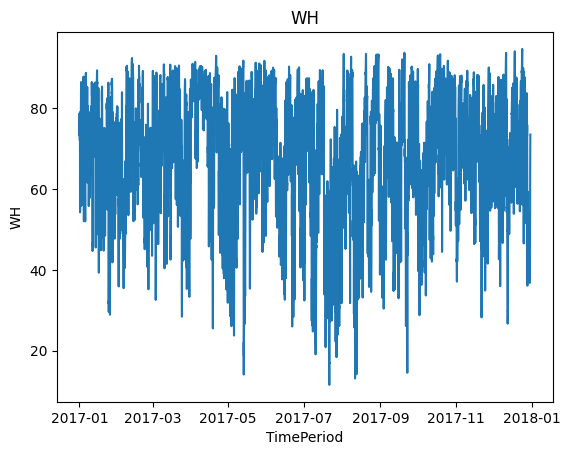

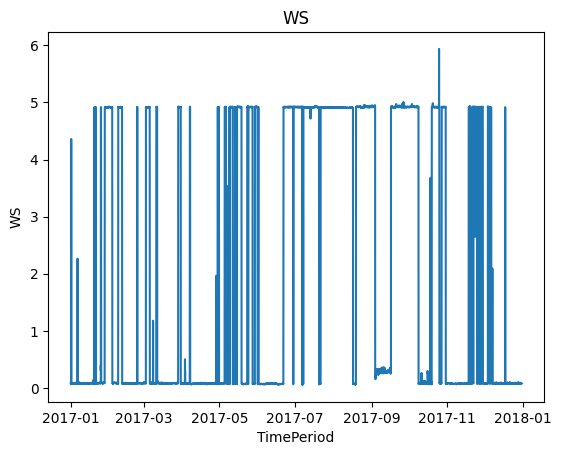

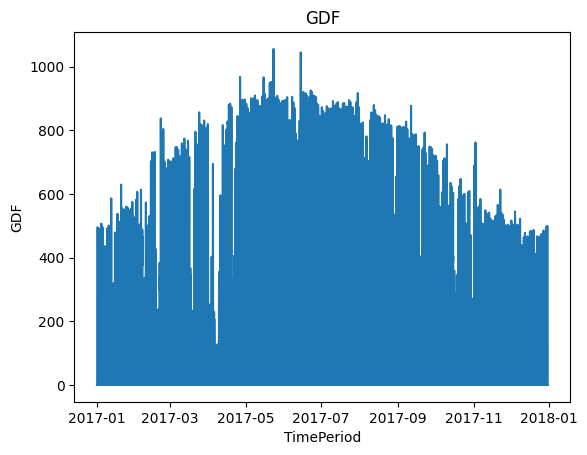

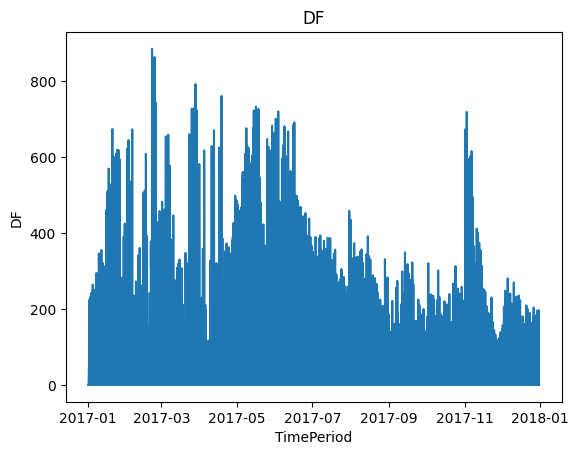

In [23]:
for feature in features:
    sns.lineplot(data[feature])
    plt.title(feature)
    plt.show()

<Axes: >

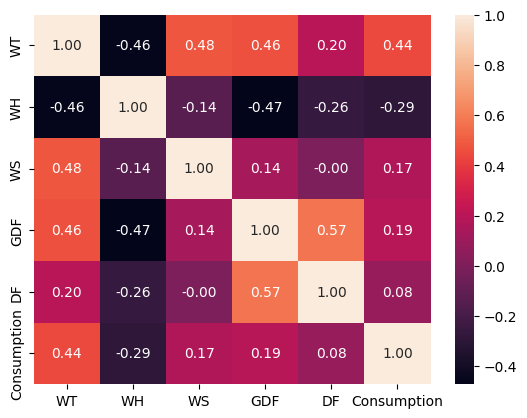

In [24]:
sns.heatmap(data.corr(), annot=True, fmt='.2f')    

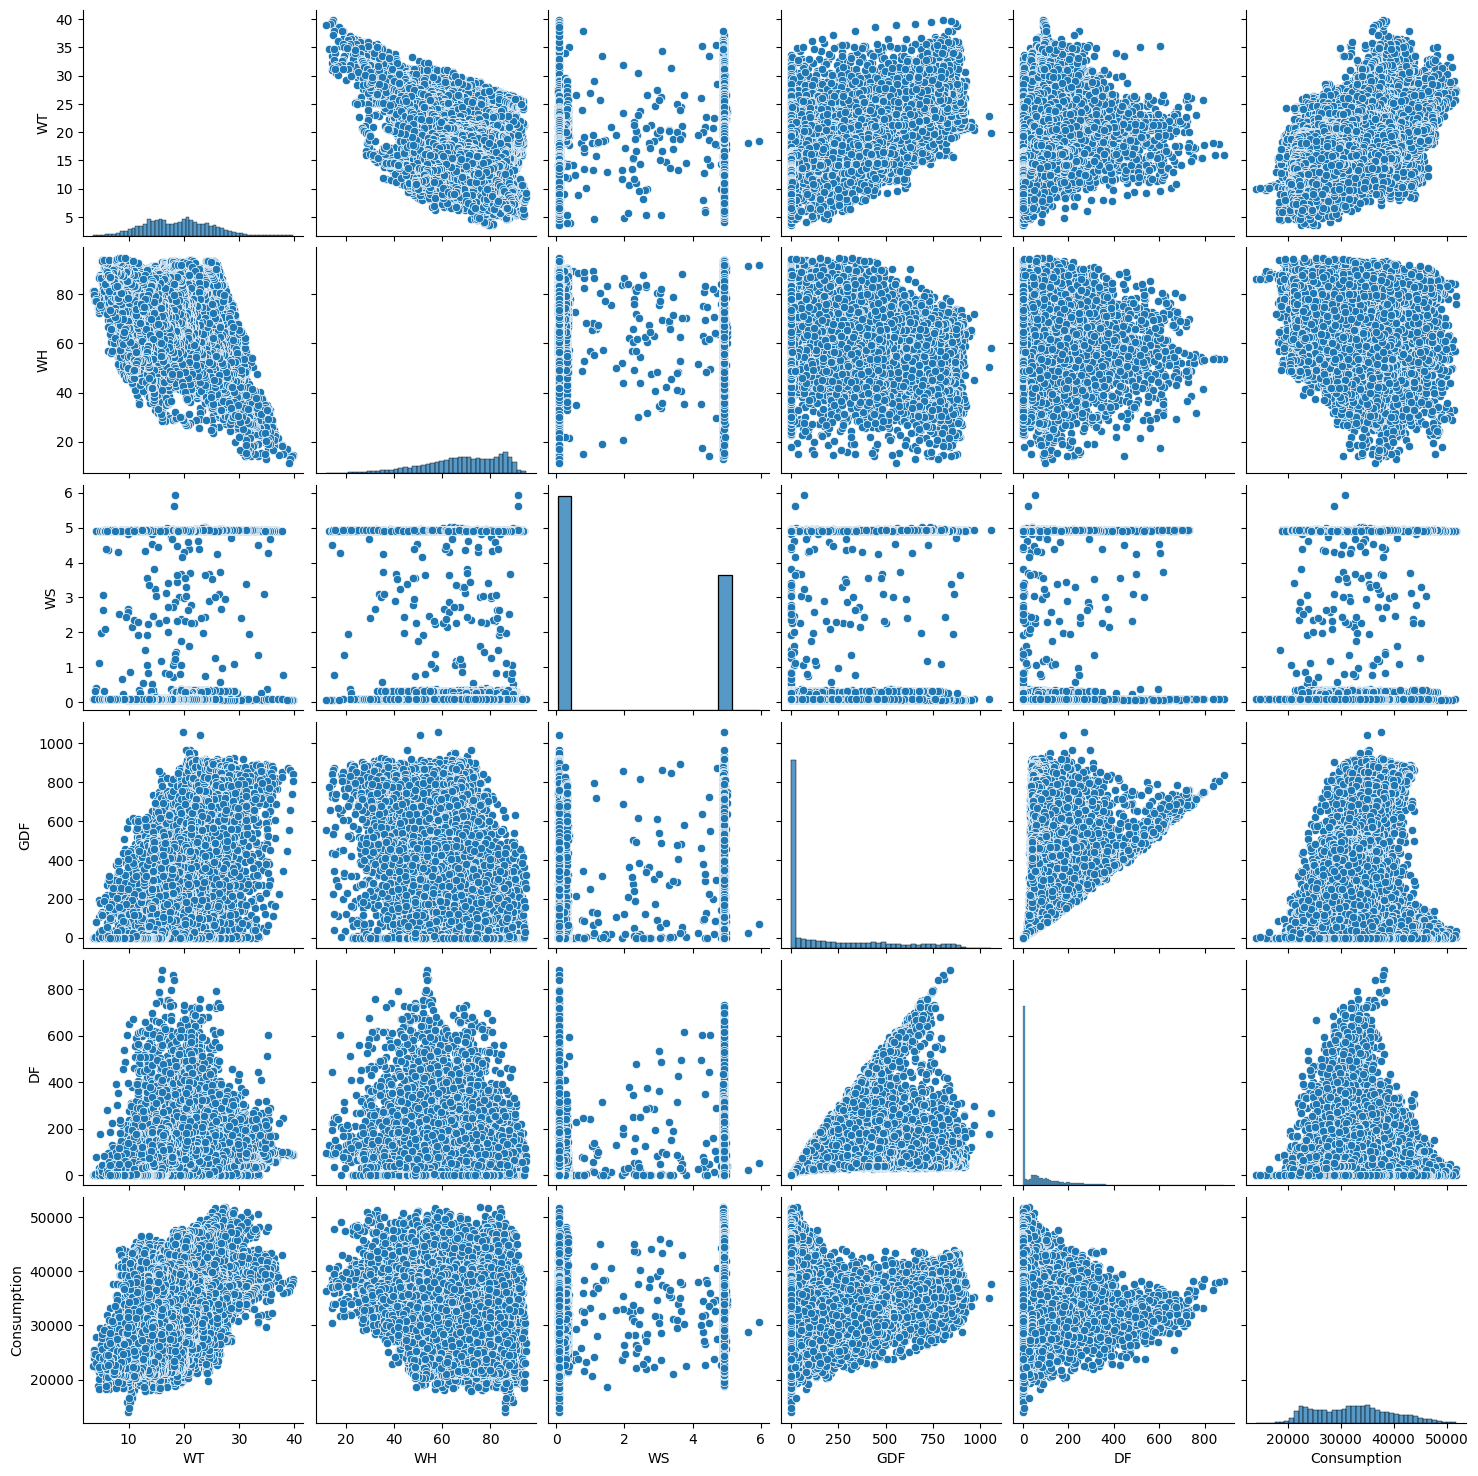

In [25]:
sns.pairplot(data)

In [27]:
lags = range(9, 0, -1)
list(lags)

[9, 8, 7, 6, 5, 4, 3, 2, 1]

In [29]:
cols = data.columns.tolist()
cols

['WT', 'WH', 'WS', 'GDF', 'DF', 'Consumption']

In [30]:
for lag in lags:
    for column in cols:
        data[f"{column}_{lag}"] = data[column].shift(lag)
data

,WT,WH,WS,GDF,DF,Consumption,WT_9,WH_9,WS_9,GDF_9,...,WS_2,GDF_2,DF_2,Consumption_2,WT_1,WH_1,WS_1,GDF_1,DF_1,Consumption_1
TimePeriod,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.351750,74.450000,0.082250,0.068500,0.10000,30306.835442,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01 00:38:00,5.709750,77.050000,0.081750,0.052500,0.09550,26351.392405,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.351750,74.450000,0.082250,0.068500,0.10000,30306.835442
2017-01-01 01:16:00,5.539000,77.400000,0.081750,0.059500,0.12150,24124.556962,NaN,NaN,NaN,NaN,...,0.082250,0.068500,0.10000,30306.835442,5.709750,77.050000,0.081750,0.052500,0.09550,26351.392405
2017-01-01 01:54:00,4.974750,78.850000,0.082750,0.066250,0.11950,22332.151897,NaN,NaN,NaN,NaN,...,0.081750,0.052500,0.09550,26351.392405,5.539000,77.400000,0.081750,0.059500,0.12150,24124.556962
2017-01-01 02:32:00,5.198667,78.700000,0.082000,0.059667,0.13500,21425.822783,NaN,NaN,NaN,NaN,...,0.081750,0.059500,0.12150,24124.556962,4.974750,78.850000,0.082750,0.066250,0.11950,22332.151897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 21:02:00,7.826667,70.576667,0.081333,0.068333,0.09900,35581.242077,14.4275,41.83125,0.07775,343.700000,...,0.074000,0.040500,0.11325,37174.144485,9.062500,64.752500,0.085000,0.071500,0.09625,36720.912548
2017-12-30 21:40:00,7.880000,69.855000,0.081250,0.067750,0.09550,34679.847910,14.2800,41.68250,0.07650,251.250000,...,0.085000,0.071500,0.09625,36720.912548,7.826667,70.576667,0.081333,0.068333,0.09900,35581.242077
2017-12-30 22:18:00,7.465000,70.825000,0.082250,0.056750,0.11125,33575.665400,14.1650,41.69500,0.07775,152.400000,...,0.081333,0.068333,0.09900,35581.242077,7.880000,69.855000,0.081250,0.067750,0.09550,34679.847910


In [31]:
features

['WT', 'WH', 'WS', 'GDF', 'DF']

In [32]:
data.drop(columns=features, inplace=True)

In [33]:
data.dropna(axis=0, inplace=True)

In [34]:
data

,Consumption,WT_9,WH_9,WS_9,GDF_9,DF_9,Consumption_9,WT_8,WH_8,WS_8,...,WS_2,GDF_2,DF_2,Consumption_2,WT_1,WH_1,WS_1,GDF_1,DF_1,Consumption_1
TimePeriod,,,,,,,,,,,,,,,,,,,,,
2017-01-01 05:42:00,21847.088610,6.351750,74.45000,0.08225,0.068500,0.100000,30306.835442,5.709750,77.0500,0.08175,...,0.081250,0.056750,0.129750,20465.316455,4.826000,75.050000,0.080750,0.055750,0.124250,20726.582277
2017-01-01 06:20:00,21435.949365,5.709750,77.05000,0.08175,0.052500,0.095500,26351.392405,5.539000,77.4000,0.08175,...,0.080750,0.055750,0.124250,20726.582277,4.418333,76.600000,0.080667,0.073000,0.121333,21847.088610
2017-01-01 06:58:00,18783.797470,5.539000,77.40000,0.08175,0.059500,0.121500,24124.556962,4.974750,78.8500,0.08275,...,0.080667,0.073000,0.121333,21847.088610,4.596750,75.750000,0.083000,0.067000,0.117750,21435.949365
2017-01-01 07:36:00,18370.632910,4.974750,78.85000,0.08275,0.066250,0.119500,22332.151897,5.198667,78.7000,0.08200,...,0.083000,0.067000,0.117750,21435.949365,4.415500,74.300000,0.082500,0.063500,0.131000,18783.797470
2017-01-01 08:14:00,20064.303797,5.198667,78.70000,0.08200,0.059667,0.135000,21425.822783,5.013000,77.1000,0.08325,...,0.082500,0.063500,0.131000,18783.797470,4.665500,72.075000,0.083000,0.320250,0.321750,18370.632910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 21:02:00,35581.242077,14.427500,41.83125,0.07775,343.700000,50.692500,28660.076047,14.280000,41.6825,0.07650,...,0.074000,0.040500,0.113250,37174.144485,9.062500,64.752500,0.085000,0.071500,0.096250,36720.912548
2017-12-30 21:40:00,34679.847910,14.280000,41.68250,0.07650,251.250000,196.250000,28209.885933,14.165000,41.6950,0.07775,...,0.085000,0.071500,0.096250,36720.912548,7.826667,70.576667,0.081333,0.068333,0.099000,35581.242077
2017-12-30 22:18:00,33575.665400,14.165000,41.69500,0.07775,152.400000,186.900000,29700.380230,13.600000,45.8700,0.07825,...,0.081333,0.068333,0.099000,35581.242077,7.880000,69.855000,0.081250,0.067750,0.095500,34679.847910


In [58]:
from sklearn.model_selection import train_test_split

In [59]:
x, y = data.drop(columns=['Consumption']), data['Consumption']

In [60]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.20, shuffle=False)

In [61]:
from sklearn.preprocessing import MinMaxScaler

In [62]:
scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [63]:
scaler = MinMaxScaler()
train_y = scaler.fit_transform(train_y.to_numpy().reshape(-1, 1))

In [64]:
lag = 9
(train_x.shape[0], lag, (train_x.shape[1] // lag))

(11028, 9, 6)

In [65]:
train_x = train_x.reshape((train_x.shape[0], lag, (train_x.shape[1] // lag)))
test_x = test_x.reshape((test_x.shape[0], lag, (test_x.shape[1] // lag)))

In [66]:
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense

In [67]:
train_x.shape

(11028, 9, 6)

In [68]:
model = Sequential([
    Input((train_x.shape[1], train_x.shape[2],)),
    LSTM(64, activation="relu", return_sequences=True),
    LSTM(32, activation="relu"),
    Dense(1, activation="linear")
])

In [69]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 9, 64)          │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["mean_squared_error"],
)

In [71]:
history = model.fit(train_x, train_y, validation_split=0.20, epochs=10, batch_size=64, shuffle=False)

Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0761 - mean_squared_error: 0.0761 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.00

<Axes: >

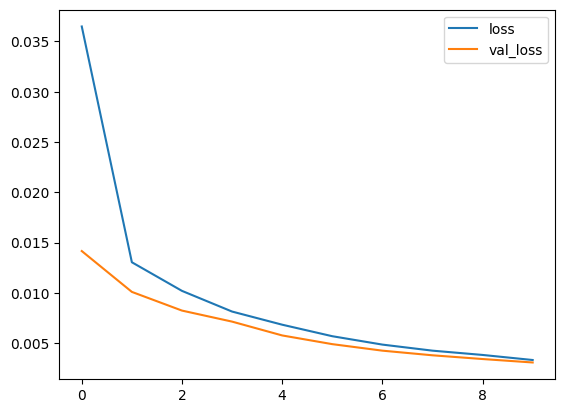

In [72]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [73]:
pred_y = model.predict(test_x)

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [74]:
pred_y = scaler.inverse_transform(pred_y)

In [75]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
(mean_absolute_error(test_y, pred_y), mean_squared_error(test_y, pred_y), r2_score(test_y, pred_y))

(1687.5797755257827, 4360918.157176082, 0.8845145801494398)

<Axes: xlabel='TimePeriod'>

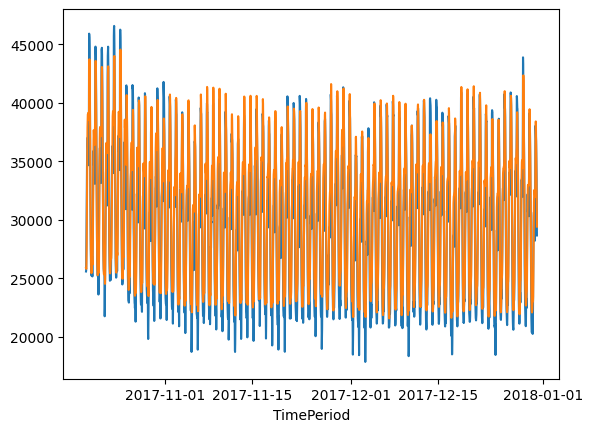

In [76]:
sns.lineplot(x=test_y.index, y=test_y.values)
sns.lineplot(x=test_y.index, y=pred_y.flatten())